## Parameterizing Sensible Heatflux via SST and $T_{air}$ differences

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [35]:
dxx=2


In [119]:
sns.set_style("darkgrid")

In [12]:
def tophat_bandpass_2d(data,lowcut=40,highcut=1):
    from scipy.signal import convolve2d
    BandFilt=data.copy()
    
    for idd in range(data.shape[0]):
        lowcut= int(np.round(lowcut))

        y,x = np.ogrid[-lowcut: lowcut+1, -lowcut: lowcut+1]
        disklow = x**2+y**2 <= lowcut**2
        disklow = disklow.astype(float)
        disklow = disklow/sum(sum(disklow))
        # DiskLow = xr.DataArray(disklow, dims=['kx', 'ky']) 
        
        # convolute the fields with the kernel
        lowfiltered = convolve2d(data[idd],disklow, mode='same', boundary='fill', fillvalue=0)
        
        # LowFilt=data.copy()
        # LowFilt[idd].data=lowfiltered
        # LowPrime=data[idd]-LowFilt
        lowprime=data[idd]-lowfiltered

        highcut= int(np.round(highcut))

        y,x = np.ogrid[-highcut: highcut+1, -highcut: highcut+1]
        diskhigh = x**2+y**2 <= highcut**2
        diskhigh = diskhigh.astype(float)
        diskhigh = diskhigh/sum(sum(diskhigh))

        # convolute the fields with the kernel
        # bandfiltered = convolve2d(LowPrime,diskhigh, mode='same', boundary='fill', fillvalue=0)
        bandfiltered = convolve2d(lowprime,diskhigh, mode='same', boundary='fill', fillvalue=0)

        # BandFilt=data.copy()
        BandFilt[idd]=bandfiltered
        
        
    return BandFilt

In [2]:

chunk={'time_counter':20}
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[-7:],chunks=chunk)


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[2:],chunks=chunk)

In [3]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [203]:
# %%time
# chunks_new={'time_counter':15}

# sstt=vart.SST.chunk(chunks=chunks_new)-273.15;
# sstt=sstt[:,1:-1,1:-1]
# sstt=sstt[:,30:-30,30:200].compute();

# hfxt=vart.HFX.chunk(chunks=chunks_new);
# hfxt=hfxt[:,1:-1,1:-1]
# hfxt=hfxt[:,30:-30,30:200].compute();

# tat=vart.T2.chunk(chunks=chunks_new)-273.15;
# tat=tat[:,1:-1,1:-1]
# tat=tat[:,30:-30,30:200].compute();

In [21]:
%%time
chunks_new={'time_counter':15}

sstf=varf.SST.chunk(chunks=chunks_new)-273.15;
sstf=sstf[:,1:-1,1:-1]
sstf=sstf[:,30:-30,30:200].compute();

hfxf=varf.HFX.chunk(chunks=chunks_new);
hfxf=hfxf[:,1:-1,1:-1]
hfxf=hfxf[:,30:-30,30:200].compute();

taf=varf.T2.chunk(chunks=chunks_new)-273.15;
taf=taf[:,1:-1,1:-1]
taf=taf[:,30:-30,30:200].compute();


CPU times: user 258 ms, sys: 148 ms, total: 406 ms
Wall time: 260 ms


In [244]:
wf=varf.WSPD10.chunk(chunks=chunks_new);
wf=wf[:,1:-1,1:-1]
wf=wf[:,30:-30,30:200].compute();


lhf=varf.LH.chunk(chunks=chunks_new);
lhf=lhf[:,1:-1,1:-1]
lhf=lhf[:,30:-30,30:200].compute();



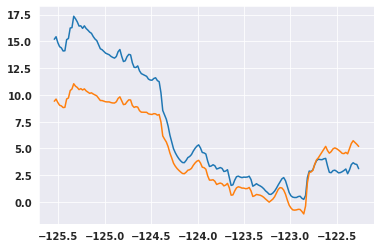

In [247]:
plt.figure()
plt.plot(hfxf.nav_lon[100,:],hfxf[0,100,:])
# plt.plot(hfxf.nav_lon[100,:],(sstf-taf)[0,100,:])
# plt.figure()
plt.plot(hfxf.nav_lon[100,:],(1.25*(1004/1000)*(sstf-taf)*(wf))[0,100,:])


# plt.plot(

(-10.0, 10.0)

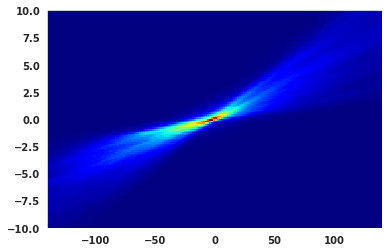

In [182]:
plt.hist2d(np.ravel((taf-sstf)*wf),np.ravel(hfxf),bins=1000,cmap='jet')
plt.xlim(-140,140)
plt.ylim(-10,10)

In [211]:
np.corrcoef(np.ravel((taf-sstf)*wf),np.ravel(hfxf))

array([[ 1.        , -0.99680135],
       [-0.99680135,  1.        ]])

In [9]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.compute())

In [95]:
dec=1
sstf_band=tophat_bandpass_2d(sstf[::dec],lowcut=15,highcut=0)
hfxf_band=tophat_bandpass_2d(hfxf[::dec],lowcut=15,highcut=0)
taf_band=tophat_bandpass_2d(taf[::dec],lowcut=15,highcut=0)





In [94]:
# %%time
# sstf_band=tophat_bandpass_2d(sstf[:1],lowcut=15,highcut=0)
# hfxf_band=tophat_bandpass_2d(hfxf[:1],lowcut=15,highcut=0)
# taf_band=tophat_bandpass_2d(taf[:1],lowcut=15,highcut=0)

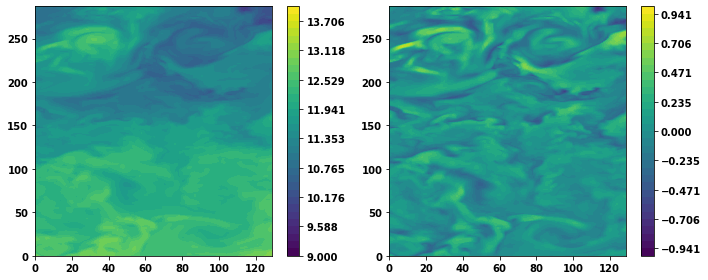

In [96]:
xlim=20
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(sstf[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(9,14,35))
plt.colorbar()


plt.subplot(1,2,2)
plt.contourf(sstf_band[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(-1,1,35))
plt.colorbar()

plt.tight_layout()

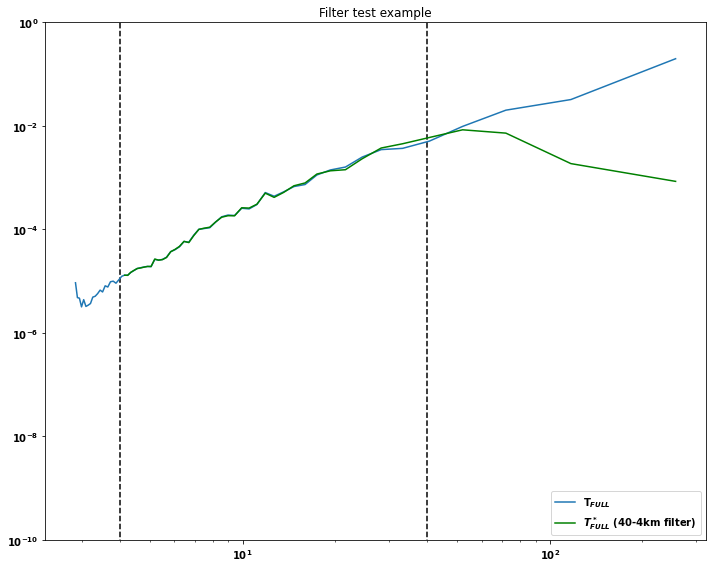

In [97]:
xlim=20
asp=xrft.isotropic_power_spectrum(sstf[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat', 'nav_lon']),dim=['x','y'],nfactor=2,dimtruncate='True',detrend='linear', window=True)
bsp=xrft.isotropic_power_spectrum(sstf_band[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat', 'nav_lon']),dim=['x','y'],nfactor=2,truncate='True',detrend='linear', window=True)


plt.figure(figsize=(10,8))
# plt.plot([1/40,1/40],[1e-12,1],'k--')
# plt.plot([1/4,1/4],[1e-12,1],'k--')

plt.plot([40,40],[1e-12,1],'k--')
plt.plot([4,4],[1e-12,1],'k--')


plt.title('Filter test example')
plt.plot(1/(asp.freq_r/dxx),asp,label=r'T$_{FULL}$')
plt.plot(1/(bsp.freq_r/dxx),bsp,color='green',label=r'$T^*_{FULL}$ (40-4km filter)')




plt.legend()

plt.yscale('log')
plt.xscale('log')

plt.ylim(1e-10,1)
plt.tight_layout()

In [100]:
ddec=1
xlim=1
# np.corrcoef(np.ravel(sstf[:,xlim:-xlim,xlim:-xlim])[::ddec],np.ravel(hfxf[:,xlim:-xlim,xlim:-xlim])[::ddec])
# np.corrcoef(np.ravel(taf[:,xlim:-xlim,xlim:-xlim])[::ddec],np.ravel(hfxf[:,xlim:-xlim,xlim:-xlim])[::ddec])
# np.corrcoef(np.ravel(sstf[:,xlim:-xlim,xlim:-xlim]-taf[:,xlim:-xlim,xlim:-xlim])[::ddec],np.ravel(hfxf[:,xlim:-xlim,xlim:-xlim])[::ddec])
np.corrcoef(np.ravel(sstf_band[:,xlim:-xlim,xlim:-xlim]-taf_band[:,xlim:-xlim,xlim:-xlim])[::ddec],np.ravel(hfxf_band[:,xlim:-xlim,xlim:-xlim])[::ddec])




array([[1.        , 0.92618513],
       [0.92618513, 1.        ]])

In [102]:
ddec=2
regtotal=pd.DataFrame({'HFX':np.ravel(hfxf[:,xlim:-xlim,xlim:-xlim])[::ddec],
                       'Tair':np.ravel(taf[:,xlim:-xlim,xlim:-xlim])[::ddec],
                       'SST':np.ravel(sstf[:,xlim:-xlim,xlim:-xlim])[::ddec]})

regband=pd.DataFrame({'HFX':np.ravel(hfxf_band[:,xlim:-xlim,xlim:-xlim])[::ddec],
                      'Tair':np.ravel(taf_band[:,xlim:-xlim,xlim:-xlim])[::ddec],
                      'SST':np.ravel(sstf_band[:,xlim:-xlim,xlim:-xlim])[::ddec]})


In [113]:
r2total=np.zeros([hfxf.shape[0]])*np.nan;
r2band=np.zeros([hfxf.shape[0]])*np.nan;



for icc in range(r2total.shape[0]):
    r2total[icc]=np.corrcoef(np.ravel((sstf-taf)[icc,xlim:-xlim,xlim:-xlim]),
                             np.ravel(hfxf[icc,xlim:-xlim,xlim:-xlim]))[0][1]
    r2band[icc]=np.corrcoef(np.ravel((sstf_band-taf_band)[icc,xlim:-xlim,xlim:-xlim]),
                             np.ravel(hfxf_band[icc,xlim:-xlim,xlim:-xlim]))[0][1]



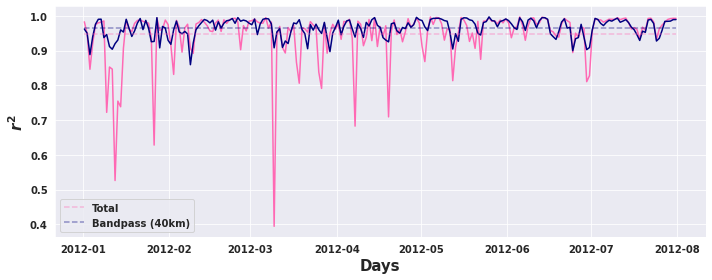

In [248]:
plt.figure(figsize=(10,4))
plt.plot(timer[::dec],r2total,'hotpink')
plt.plot(timer[::dec],r2band,'navy')

plt.plot(timer,np.nanmean(r2total)+np.zeros(timer.shape),'k--',color='hotpink',alpha=0.4,label='Total')
plt.plot(timer,np.nanmean(r2band)+np.zeros(timer.shape),'k--',color='navy',alpha=0.4,label='Bandpass (40km)')


plt.ylabel(r'$r^{2}$',fontsize=15,fontweight='bold')
plt.xlabel('Days',fontsize=15,fontweight='bold')
plt.legend()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/SST-TairxHFX_correlation_timeseries.png')

plt.tight_layout()

In [ ]:
np.pol

In [135]:
# atotal,btotal=np.polyfit(regtotal.SST - regtotal.Tair ,regtotal.HFX,deg=1)
# aband,bband=np.polyfit(regtotal.SST - regtotal.Tair ,regtotal.HFX,deg=1)


atotal=np.zeros(hfxf_band.shape[0])*np.nan;btotal=np.zeros(hfxf_band.shape[0])*np.nan;
aband=np.zeros(hfxf_band.shape[0])*np.nan;bband=np.zeros(hfxf_band.shape[0])*np.nan;



for ide in range(hfxf_band.shape[0]):
    decx=1
    atotal[ide],btotal[ide]=np.polyfit(np.ravel((sstf-taf)[ide,xlim:-xlim,xlim:-xlim]),
                             np.ravel(hfxf[ide,xlim:-xlim,xlim:-xlim]),deg=1);
    
    aband[ide],bband[ide]=np.polyfit(np.ravel((sstf_band-taf_band)[ide,xlim:-xlim,xlim:-xlim]),
                             np.ravel(hfxf_band[ide,xlim:-xlim,xlim:-xlim]),deg=1);




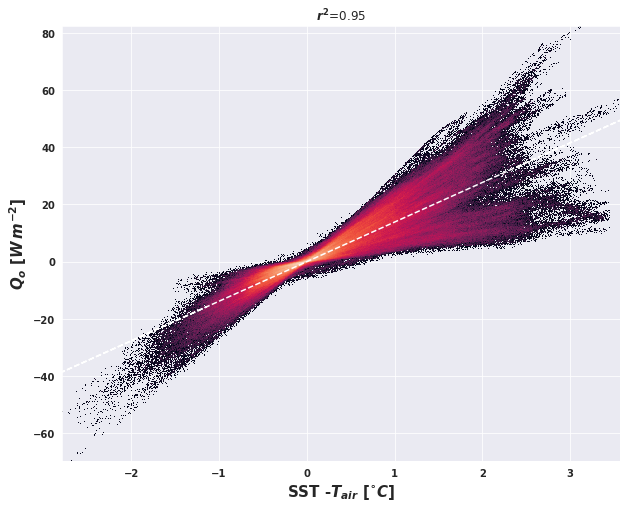

In [162]:
import matplotlib as mpl


plt.figure(figsize=(10,8))
plt.hist2d((regtotal.SST - regtotal.Tair),regtotal.HFX,bins=1000,density=True,norm=mpl.colors.LogNorm())
# plt.hist2d(reg_fbar.SST,reg_fbar.HFX,bins=1000)
# plt.plot((regtotal.SST - regtotal.Tair[::dec]),(atotal*(regtotal.SST - regtotal.Tair))[::dec],'w--',alpha=1)
plt.plot((regtotal.SST - regtotal.Tair[::dec]),(np.nanmean(atotal)*(regtotal.SST - regtotal.Tair))[::dec],'w--',alpha=1)


# plt.xlim(-2,2)
# plt.ylim(-60,60)
plt.xlabel(r'SST -$T_{air}$ [$^{\circ}C$]',fontsize=15,fontweight='bold')

plt.ylabel(r'$Q_{o}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r^{2}$'+'={0:.2f}'.format(r2total.mean()))
plt.grid(color='w')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/SST-TairxHFX(Total)_2d_histogram.png')



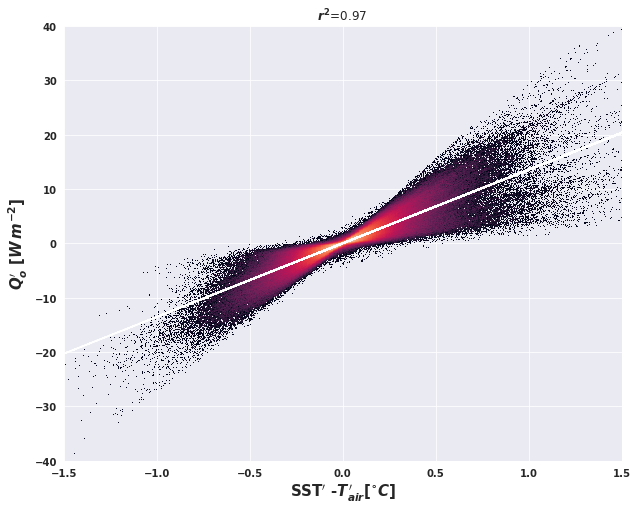

In [163]:
import matplotlib as mpl


plt.figure(figsize=(10,8))
plt.hist2d((regband.SST - regband.Tair),regband.HFX,bins=1000,density=True,norm=mpl.colors.LogNorm())
# plt.hist2d(reg_fbar.SST,reg_fbar.HFX,bins=1000)
# plt.plot((regtotal.SST - regtotal.Tair[::dec]),(atotal*(regtotal.SST - regtotal.Tair))[::dec],'w--',alpha=1)
plt.plot((regband.SST - regband.Tair[::dec]),(np.nanmean(aband)*(regband.SST - regband.Tair))[::dec],'w--',alpha=1)


plt.xlim(-1.5,1.5)
plt.ylim(-40,40)
plt.xlabel(r'SST$^{\prime}$ -$T^{\prime}_{air}$[$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q^{\prime}_{o}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')

plt.title(r'$r^{2}$'+'={0:.2f}'.format(r2band.mean()))
plt.grid(color='w')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/SST-TairxHFX(Prime)_2d_histogram.png')




In [164]:
varf

<xarray.Dataset>
Dimensions:               (y: 390, x: 300, lev_M: 49, lev_W: 50, time_counter: 213, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
  * lev_M                 (lev_M) float32 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0
  * lev_W                 (lev_W) float32 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(20,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2012-01-01T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/28)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(20, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(20, 2), meta=np.ndarray>
    T2                    (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    Q2                    (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    RAINCV                (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    RAINNCV               (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    ...                    ...
    XKHH                  (time_counter, lev_M, y, x) float32 dask.array<chunksize=(20, 49, 390, 300), meta=np.ndarray>
    BN2                   (time_counter, lev_M, y, x) float32 dask.array<chunksize=(20, 49, 390, 300), meta=np.ndarray>
    AKMS                  (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    AKHS                  (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    EXCH_H                (time_counter, lev_W, y, x) float32 dask.array<chunksize=(20, 50, 390, 300), meta=np.ndarray>
    EXCH_M                (time_counter, lev_W, y, x) float32 dask.array<chunksize=(20, 50, 390, 300), meta=np.ndarray>
Attributes: (12/100)
    name:                            Out/wrf_3D_Y2012M01_DAY
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2020-Jul-30 22:34:33 GMT
    uuid:                            42198aea-d8e9-4067-956c-4346ac67e533
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2